# PUB - cell state probe

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

%load_ext autoreload
%autoreload 2

data_dir = Path("/datadrive/data")

# Load the data

In [2]:
# run_dir = Path("/datadrive/data/runs/azure_nh_runoff_30EPOCH_0306_173310")
# run_dir = Path("/datadrive/data/runs/azure_nh_runoff_30EPOCH_0306_200242")
run_dir = Path("/home/tommy/neuralhydrology/runs/lstm_PUB_azure_3006_101251")

# load config
cfg = Config(run_dir / "config.yml")
cfg.run_dir = run_dir

In [3]:
res_fp = get_test_filepath(run_dir, epoch=30)
preds = get_all_station_ds(res_fp)
preds["station_id"] = preds["station_id"].astype(int)

100%|██████████| 134/134 [00:00<00:00, 1984.52it/s]


# Load model

In [4]:
# load trained model
model = get_model(cfg).to(cfg.device)
_load_weights(model, cfg)
model

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


Using the model weights from /home/tommy/neuralhydrology/runs/lstm_PUB_azure_3006_101251/model_epoch030.pt


CudaLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (lstm): LSTM(25, 64)
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

## Get training/test dataset

In [57]:
from scripts.cell_state.utils import (
    read_basin_list, 
    get_train_test_cell_states, 
    normalize_and_convert_dimension_to_variable_for_cell_state_data, 
    create_train_test_default_dict_for_all_target_vars, 
    train_and_evaluate_models
)

In [55]:
ds = xr.open_dataset("/home/tommy/spatio_temporal/data/ALL_dynamic_ds.nc")

train_sids = read_basin_list(cfg.train_basin_file)
test_sids = read_basin_list(cfg.test_basin_file)
train_ds = ds.sel(time=slice(cfg.train_start_date, cfg.train_end_date), station_id=np.isin(ds.station_id, train_sids.station_id))
test_ds = ds.sel(time=slice(cfg.test_start_date, cfg.test_end_date), station_id=np.isin(ds.station_id, test_sids.station_id))

out_of_sample = not all(np.isin(test_sids, train_sids))
print(f"Out of Sample: {not all(np.isin(test_sids, train_sids))}")

Out of Sample: True


## Probe the basins

In [60]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

train_cn, test_cn = get_train_test_cell_states(run_dir, cfg)

# Normalisation strategy - global or local?

In [65]:
# Path("/home/tommy/neuralhydrology/runs/lstm_PUB_azure_3006_101251/cell_states/global_train_cs.nc").unlink()
# Path("/home/tommy/neuralhydrology/runs/lstm_PUB_azure_3006_101251/cell_states/global_test_cs.nc").unlink()

In [66]:
train_cs = normalize_and_convert_dimension_to_variable_for_cell_state_data(
    cn=train_cn,
    out_dir=out_dir, 
    per_basin=PER_BASIN,
    train_test="train",
    time_dim="date",
    reload=True
)

test_cs = normalize_and_convert_dimension_to_variable_for_cell_state_data(
    cn=test_cn,
    out_dir=out_dir, 
    per_basin=PER_BASIN,
    train_test="test",
    time_dim="date",
    reload=True
)

print("DONE")

Calculating Normalisation for `train` data: global
Calculating Normalisation for `test` data: global
DONE


In [68]:
train_cs["station_id"] = train_cs["station_id"].astype(int)
test_cs["station_id"] = test_cs["station_id"].astype(int)

train_cs = train_cs if (not "date" in train_cs.coords) else train_cs.rename({"date": "time"})
test_cs = test_cs if (not "date" in test_cs.coords) else test_cs.rename({"date": "time"})

# Target Data

In [69]:
from scripts.cell_state.normalize import normalize_2d_dataset


if TARGET == "ERA5":
    filepath = data_dir / "camels_basin_ERA5Land_sm.nc"
    era5_ds = xr.open_dataset(filepath)

    if not isinstance(era5_ds, xr.Dataset):
        era5_ds = era5_ds.to_dataset()

    for var in era5_ds.data_vars:
        era5_ds[var] = normalize_2d_dataset(era5_ds, variable_str=var, per_basin=PER_BASIN)

    era5_ds["station_id"] = era5_ds["station_id"].astype(int)

    # NOT for snow depth ..?
    era5_ds = era5_ds.drop("sd")
    target_ds = era5_ds

elif TARGET == "ESA":
    filepath = data_dir / "SOIL_MOISTURE/interp_full_timeseries_esa_cci_sm.nc"
    esa_ds = xr.open_dataset(filepath).drop("spatial_ref")
    if not isinstance(esa_ds, xr.Dataset):
        esa_ds = esa_ds.to_dataset()

    for var in esa_ds.data_vars:
        esa_ds[var] = normalize_2d_dataset(esa_ds, variable_str=var, per_basin=PER_BASIN)

    esa_ds["station_id"] = esa_ds["station_id"].astype(int)
    target_ds = esa_ds
else:
    assert False
    

# Reference Model Train

In [70]:
train_target_ds = target_ds.sel(station_id=np.isin(target_ds.station_id, train_cs.station_id), time=np.isin(target_ds.time, train_cs.time))
test_target_ds = target_ds.sel(station_id=np.isin(target_ds.station_id, test_cs.station_id), time=np.isin(target_ds.time, test_cs.time))

input_variables = list(train_cs.data_vars)
seq_length = 1
basin_dim = "station_id"
time_dim = "time"

In [71]:
all_train_test = create_train_test_default_dict_for_all_target_vars(
    train_cs=train_cs,
    test_cs=test_cs,
    train_target_ds=train_target_ds,
    test_target_ds=test_target_ds,
    input_variables=input_variables,
)

** STARTING swvl1 **


Extracting Data: 100%|██████████| 7618/7618 [00:58<00:00, 129.90it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 2087/2087 [00:14<00:00, 140.47it/s]


Merging and reshaping arrays
** STARTING swvl2 **


Extracting Data: 100%|██████████| 7621/7621 [00:53<00:00, 142.27it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 2087/2087 [00:14<00:00, 142.38it/s]


Merging and reshaping arrays
** STARTING swvl3 **


Extracting Data: 100%|██████████| 7618/7618 [00:55<00:00, 137.89it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 2087/2087 [00:14<00:00, 142.32it/s]


Merging and reshaping arrays
** STARTING swvl4 **


Extracting Data: 100%|██████████| 7618/7618 [00:55<00:00, 137.10it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 2087/2087 [00:14<00:00, 141.86it/s]


Merging and reshaping arrays


In [72]:
all_models_preds = train_and_evaluate_models(all_train_test)

** swvl1 linear model **
-- Epoch 1
Norm: 0.96, NNZs: 42, Bias: -0.059347, T: 1755151, Avg. loss: 0.041190
Total training time: 1.23 seconds.
-- Epoch 2
Norm: 0.96, NNZs: 43, Bias: -0.061055, T: 3510302, Avg. loss: 0.041062
Total training time: 2.58 seconds.
-- Epoch 3
Norm: 0.95, NNZs: 43, Bias: -0.061896, T: 5265453, Avg. loss: 0.041060
Total training time: 3.96 seconds.
-- Epoch 4
Norm: 0.95, NNZs: 42, Bias: -0.062559, T: 7020604, Avg. loss: 0.041061
Total training time: 5.32 seconds.
Convergence after 4 epochs took 5.45 seconds


Calculating Errors: 100%|██████████| 133/133 [00:01<00:00, 92.62it/s, 102001]


** swvl2 linear model **
-- Epoch 1
Norm: 0.86, NNZs: 37, Bias: -0.064648, T: 1755809, Avg. loss: 0.048683
Total training time: 1.30 seconds.
-- Epoch 2
Norm: 0.86, NNZs: 39, Bias: -0.060525, T: 3511618, Avg. loss: 0.048574
Total training time: 2.71 seconds.
-- Epoch 3
Norm: 0.86, NNZs: 39, Bias: -0.054302, T: 5267427, Avg. loss: 0.048572
Total training time: 4.12 seconds.
-- Epoch 4
Norm: 0.86, NNZs: 39, Bias: -0.061458, T: 7023236, Avg. loss: 0.048571
Total training time: 5.55 seconds.
Convergence after 4 epochs took 5.68 seconds


Calculating Errors: 100%|██████████| 133/133 [00:01<00:00, 92.37it/s, 102001]


** swvl3 linear model **
-- Epoch 1
Norm: 0.96, NNZs: 43, Bias: -0.087814, T: 1755151, Avg. loss: 0.037055
Total training time: 1.26 seconds.
-- Epoch 2
Norm: 0.96, NNZs: 43, Bias: -0.093319, T: 3510302, Avg. loss: 0.036937
Total training time: 2.65 seconds.
-- Epoch 3
Norm: 0.96, NNZs: 44, Bias: -0.096478, T: 5265453, Avg. loss: 0.036931
Total training time: 4.02 seconds.
-- Epoch 4
Norm: 0.96, NNZs: 43, Bias: -0.088901, T: 7020604, Avg. loss: 0.036927
Total training time: 5.39 seconds.
Convergence after 4 epochs took 5.52 seconds


Calculating Errors: 100%|██████████| 133/133 [00:01<00:00, 92.84it/s, 102001]


** swvl4 linear model **
-- Epoch 1
Norm: 0.97, NNZs: 44, Bias: -0.055269, T: 1755151, Avg. loss: 0.037614
Total training time: 1.23 seconds.
-- Epoch 2
Norm: 0.97, NNZs: 44, Bias: -0.060157, T: 3510302, Avg. loss: 0.037485
Total training time: 2.58 seconds.
-- Epoch 3
Norm: 0.96, NNZs: 45, Bias: -0.061462, T: 5265453, Avg. loss: 0.037486
Total training time: 3.94 seconds.
-- Epoch 4
Norm: 0.96, NNZs: 46, Bias: -0.056886, T: 7020604, Avg. loss: 0.037474
Total training time: 5.28 seconds.
Convergence after 4 epochs took 5.41 seconds


Calculating Errors: 100%|██████████| 133/133 [00:01<00:00, 92.68it/s, 102001]


# Plot Results

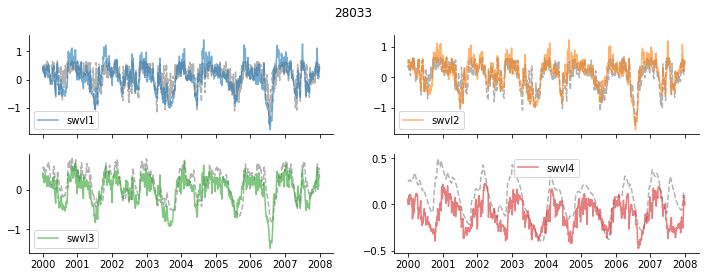

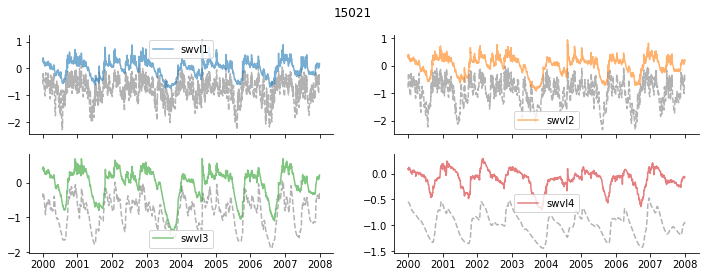

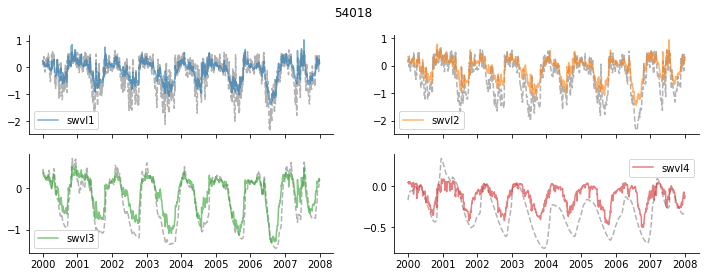

In [73]:
p = all_models_preds[target_vars[0]]["preds"]
time = slice("2000", "2007")

N = 3
pixels = np.random.choice(p.station_id.values, N, replace=False)
# pixels = [27030, 38012, 39017]

for px in pixels:
    if TARGET == "ESA":
        f, axs = plt.subplots(1, 2, figsize=(12, 4 if TARGET != "ESA" else 2), sharex=True)
    else:
        f, axs = plt.subplots(2, 2, figsize=(12, 4 if TARGET != "ESA" else 2), sharex=True)
    f.suptitle(px)
    for ix, target_var in enumerate(target_vars):
        ax = axs[np.unravel_index(ix, (2, 2)) if TARGET != "ESA" else ix]
        preds = all_models_preds[target_var]["preds"]
        data = preds.sel(station_id=px, time=time)

        ax.plot(data.time, data.obs, color="k", ls="--", alpha=0.3)
        ax.plot(data.time, data.sim, color=f"C{ix}", ls="-", alpha=0.6, label=f"{target_var}")
        ax.legend()
        sns.despine()

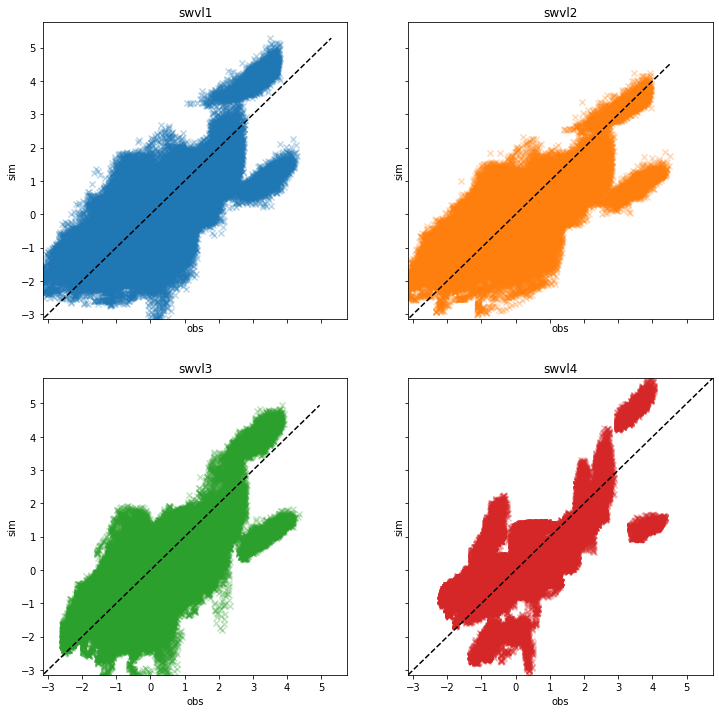

In [74]:
from scripts.plots import scatter_plot

if TARGET == "ESA":
    f, axs = plt.subplots(1, 2, figsize=(6 * 2, 6), sharex=True, sharey=True)
else:
    f, axs = plt.subplots(2, 2, figsize=(6 * 2, 6 * 2), sharex=True, sharey=True)

for ix, target_var in enumerate(target_vars):
    ax = axs[np.unravel_index(ix, (2, 2)) if TARGET != "ESA" else ix]
    preds = all_models_preds[target_var]["preds"]

    x, y = preds["obs"].values.flatten(), preds["sim"].values.flatten()
    scatter_plot(obs=x, sim=y, ax=ax, scatter_kwargs={"marker": "x", "color": f"C{ix}", "alpha": 0.3})
    ax.set_title(target_var)

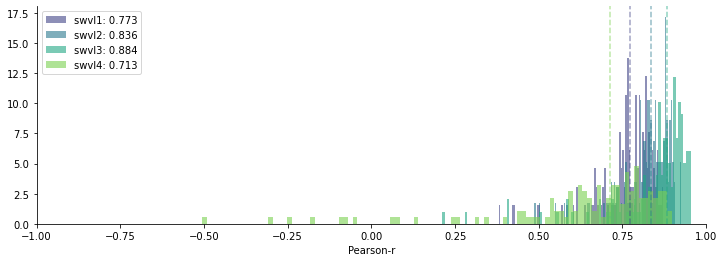

In [76]:
metric = "Pearson-r"
f, ax = plt.subplots(figsize=(12, 4))

colors = sns.color_palette("viridis", n_colors=len(target_vars))
for ix, target_var in enumerate(target_vars):
    errors = all_models_preds[target_var]["errors"]
    nse = errors[metric]

    ax.hist(nse.where(nse > -1, -1), bins=100, density=True, label=f"{target_var}: {nse.median().values:.3f}", alpha=0.6, color=colors[ix]);
    ax.axvline(nse.median(), color=colors[ix], ls="--", alpha=0.5)
    
ax.set_xlabel(metric)
ax.set_xlim(-1, 1)
ax.legend()
sns.despine()

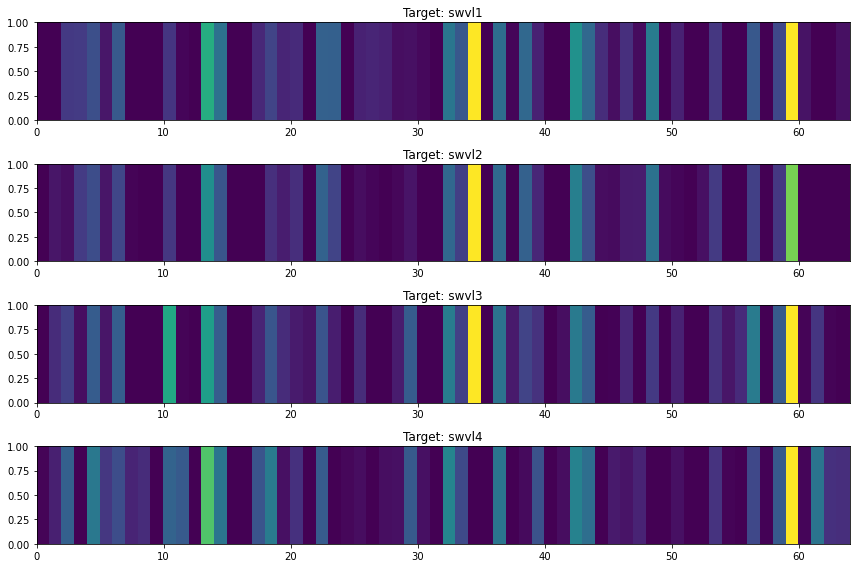

In [77]:
from scripts.cell_state.analysis import get_model_weights, plot_weights

n_plots = len(target_vars)
f, axs = plt.subplots(n_plots, 1, figsize=(12, 2*n_plots))

for ix, target_var in enumerate(target_vars):
    model = all_models_preds[target_var]["model"]
    ax = axs[ix]
    w, b = get_model_weights(model)
    plot_weights(np.abs(w), kwargs={"vmin": 0.0, "vmax": 0.3}, ax=ax, cbar=False)
    ax.set_title(f"Target: {target_var}")
plt.tight_layout()

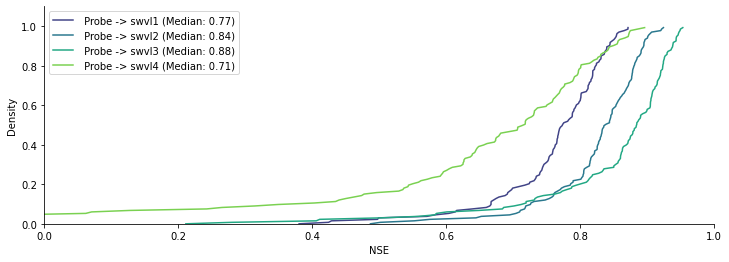

In [78]:
from typing import Any, Dict
import seaborn as sns
import matplotlib.pyplot as plt


def empirical_cdf(errors: np.ndarray, kwargs: Dict[str, Any] = {}):
    x = np.sort(errors)
    y = np.arange(len(x))/float(len(x))
    plt.plot(x, y, **kwargs)

    
f, ax = plt.subplots(figsize=(12, 4))
colors = sns.color_palette("viridis", n_colors=len(target_vars))
for ix, target_var in enumerate(target_vars):
    errors = all_models_preds[target_var]["errors"]
    nse = errors["Pearson-r"]
    med_nse = f"{(np.median(nse)):.2f}"
    empirical_cdf(nse, kwargs={"label": f" Probe -> {target_var} (Median: {med_nse})", "color": colors[ix]})

ax.set_xlim(0, 1)
ax.set_ylim(0, 1.1)
ax.set_xlabel("NSE")
ax.set_ylabel("Density")
plt.legend()
sns.despine()

In [79]:
errors

<xarray.Dataset>
Dimensions:     (station_id: 133)
Coordinates:
  * station_id  (station_id) int64 3003 7002 9002 9004 ... 94001 96001 102001
Data variables:
    NSE         (station_id) float64 -73.91 -13.61 -12.74 ... -129.9 -0.661
    Pearson-r   (station_id) float64 0.8259 0.8178 0.7971 ... 0.7063 0.5508

# What about individual cell states?

In [80]:
def get_ws_bs_for_target_var(all_models_preds, target_var: str):
    model = all_models_preds[target_var]["model"]
    w, b = get_model_weights(model)
    return w, b

In [116]:
# from scripts.cell_state.cell_state_dataset import dataset_dimensions_to_variable

# if "station_norm_cs" not in globals():
#     cn_station_mean_ = train_cn.mean(dim="date")
#     cn_station_std_ = train_cn.std(dim="date")
#     norm_test_cn = (test_cn - cn_station_mean_) / cn_station_std_

#     station_norm_cs = dataset_dimensions_to_variable(
#         norm_test_cn,
#         variable="c_n",
#         dimension_to_convert_to_variable_dim="dimension",
#         time_dim="date"
#     )
#     station_norm_cs = station_norm_cs.rename({"date": "time"})
#     station_norm_cs["station_id"] = station_norm_cs["station_id"].astype(int)
#     display(station_norm_cs)

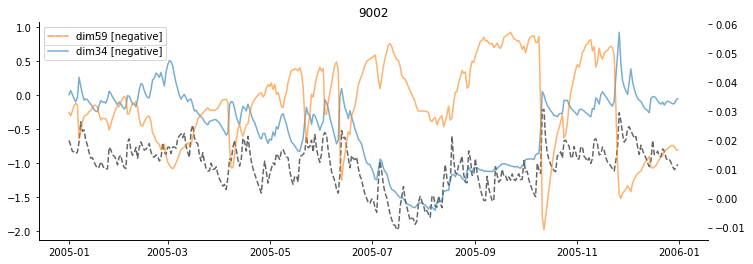

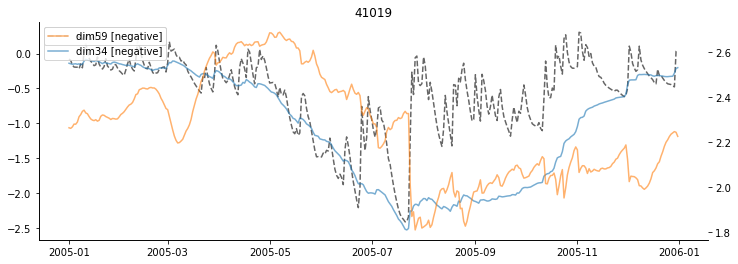

In [114]:
target_var = "7_day_smooth_sm" if TARGET == "ESA" else "swvl1"
test_cn = test_cn.rename({"date": "time"}) if "date" in test_cn.dims else test_cn
test_cn["station_id"] = test_cn["station_id"].astype(int)
test_cs = dataset_dimensions_to_variable(
    test_cn,
    variable="c_n",
    dimension_to_convert_to_variable_dim="dimension",
    time_dim="time"
)


# N_dims = 3
time = "2005"
Npxs = 2
N_dims = 2
twinx = True

w, b = get_ws_bs_for_target_var(all_models_preds, target_var)
max_idx = np.argmax(np.abs(w))
largest_n = np.abs(w).argsort()[-N_dims:][::-1]
features = [f"dim{idx}" for idx in largest_n]

pxs = np.random.choice(test_cn.station_id.values, Npxs)
# pxs = [28033, 15021, 54018]

for px in pxs:
    f, ax = plt.subplots(figsize=(12, 4))
    data = test_cs.sel(station_id=px, time=time).to_dataframe()
    target = target_ds.sel(station_id=px, time=time).to_dataframe()

    ax.plot(target.index, target[target_var], label=target_var, color="k", ls="--", alpha=0.6)
    ax.legend(loc="upper right")
    ax.set_title(px)

    for ix, feature in enumerate(features):  # features  ["dim20"]  ["dim58"]
        if (twinx) and (ix == 1):
            ax = ax.twinx()
        weight = w[largest_n][ix]
        negative = -1 if weight < 0 else 1
        ax.plot(data.index, data[feature] * negative, label=f"{feature}{' [negative]' if negative == -1 else ''}", color=f"C{ix}", alpha=0.6)
        ax.legend(loc="upper left")

    sns.despine()

# Train periods

In [41]:
preds

<xarray.Dataset>
Dimensions:     (station_id: 534, time: 3652)
Coordinates:
  * station_id  (station_id) int64 1001 2001 2002 4001 ... 97002 101002 106001
  * time        (time) datetime64[ns] 1987-12-31T23:59:45.056612352 ... 1997-...
Data variables:
    obs         (station_id, time) float32 1.048 1.068 1.088 ... 3.787 3.793
    sim         (station_id, time) float64 0.06023 0.0559 ... 3.346 3.357

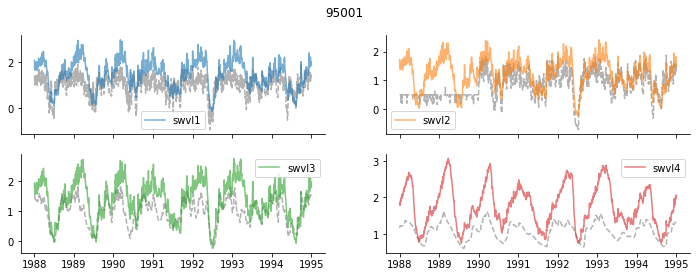

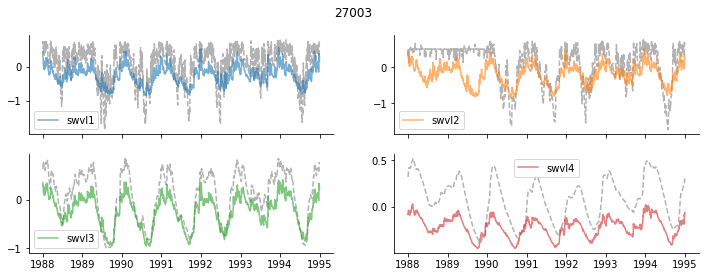

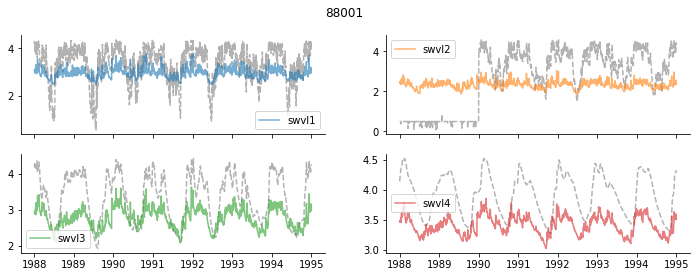

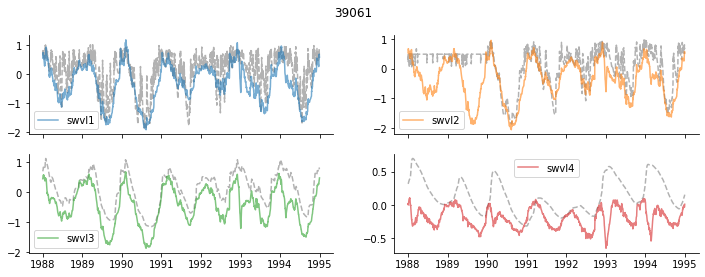

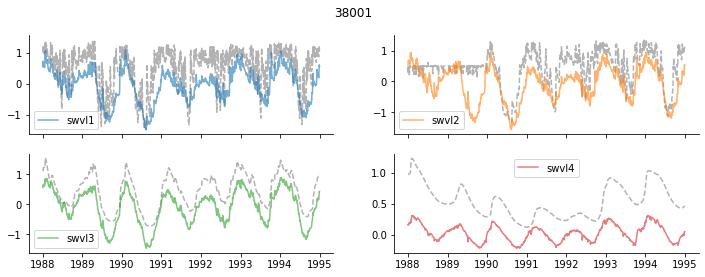

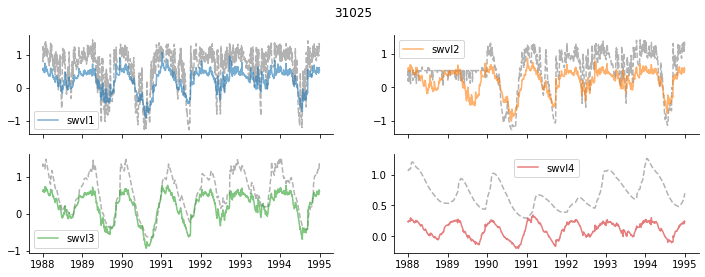

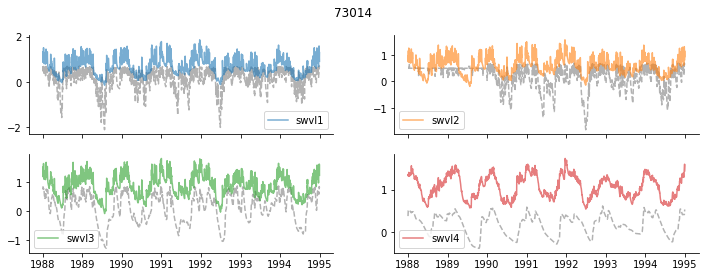

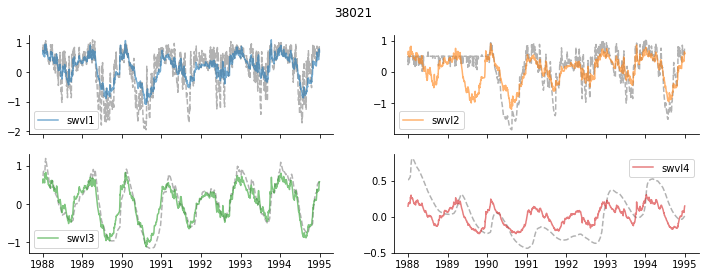

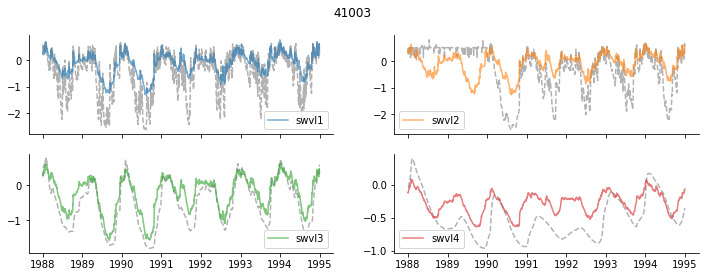

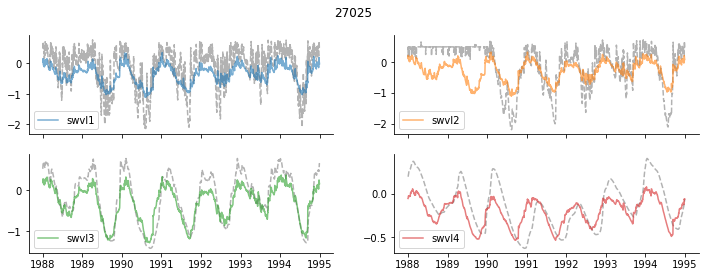

In [43]:
p = all_train_preds[target_vars[0]]["preds"]
time = slice("2000", "2007")
time = slice("1988", "1994")

N = 10
pixels = np.random.choice(p.station_id.values, N, replace=False)
# pixels = [27030, 38012, 39017]

for px in pixels:
    if TARGET == "ESA":
        f, axs = plt.subplots(1, 2, figsize=(12, 4 if TARGET != "ESA" else 2), sharex=True)
    else:
        f, axs = plt.subplots(2, 2, figsize=(12, 4 if TARGET != "ESA" else 2), sharex=True)
    f.suptitle(px)
    for ix, target_var in enumerate(target_vars):
        ax = axs[np.unravel_index(ix, (2, 2)) if TARGET != "ESA" else ix]
        preds = all_train_preds[target_var]["preds"]
        data = preds.sel(station_id=px, time=time)

        ax.plot(data.time, data.obs, color="k", ls="--", alpha=0.3)
        ax.plot(data.time, data.sim, color=f"C{ix}", ls="-", alpha=0.6, label=f"{target_var}")
        ax.legend()
        sns.despine()

# Mutual information vs. correlation vs. SGD Regressor

In [25]:
assert False

AssertionError: 

In [ ]:
df = pd.DataFrame({"regression": w}).reset_index().rename({"index": "dimension"}, axis=1)
df.head()

#### correlation

In [ ]:
var_ = "7_day_smooth_sm" if TARGET == "ESA" else "swvl1"

x = all_train_test[var_]["train"]["X"]
y = all_train_test[var_]["train"]["y"]

In [ ]:
from numpy import cov

all_cov = cov(x, y, rowvar=False, bias=False)
all_cov = all_cov[:, -1][:-1]

df["correlation"] = all_cov
df.head()

#### mutual information

In [ ]:
from sklearn.feature_selection import mutual_info_regression
from tqdm import tqdm 


all_mi = []
for dim_ix in tqdm(range(x.shape[-1])):
    mi_score = mutual_info_regression(x[:, dim_ix].reshape(-1, 1), y.ravel())[0]
    all_mi.append(mi_score)

df["mutual_information"] = all_mi

#### Plot

# Non-Linear Model

In [26]:
from scripts.cell_state.sklearn_models import fit_and_predict

if "nonlinear_dict" not in globals().keys():
    # initalise the model 
    nonlinear_dict = defaultdict(dict)
    target_vars = [v for v in target_ds.data_vars]

    for target_var in [v for v in target_ds.data_vars]:
        print(f"** {target_var} **")
        model, preds, errors = fit_and_predict(
            all_train_test[target_var]["train"], 
            all_train_test[target_var]["test"], 
            random_seed=100, 
            linear=False, 
            hidden_sizes=[10,10]
        )
        nonlinear_dict[target_var]["model"] = model
        nonlinear_dict[target_var]["preds"] = preds
        nonlinear_dict[target_var]["errors"] = errors

** swvl1 **
Iteration 1, loss = 0.11276318
Validation score: 0.874262
Iteration 2, loss = 0.08198641
Validation score: 0.881479
Iteration 3, loss = 0.07926307
Validation score: 0.886734
Iteration 4, loss = 0.07803131
Validation score: 0.888225
Iteration 5, loss = 0.07734741
Validation score: 0.888201
Iteration 6, loss = 0.07700022
Validation score: 0.888871
Iteration 7, loss = 0.07653632
Validation score: 0.889489
Iteration 8, loss = 0.07612717
Validation score: 0.891230
Iteration 9, loss = 0.07586966
Validation score: 0.890110
Iteration 10, loss = 0.07557529
Validation score: 0.892081
Iteration 11, loss = 0.07531232
Validation score: 0.892318
Iteration 12, loss = 0.07485845
Validation score: 0.892643
Iteration 13, loss = 0.07455978
Validation score: 0.893240
Iteration 14, loss = 0.07445794
Validation score: 0.894133
Iteration 15, loss = 0.07433957
Validation score: 0.892819
Iteration 16, loss = 0.07427681
Validation score: 0.893717
Iteration 17, loss = 0.07422479
Validation score: 0.8

Calculating Errors: 100%|██████████| 133/133 [00:01<00:00, 86.60it/s, 102001]


** swvl2 **
Iteration 1, loss = 0.22615908
Validation score: 0.659841
Iteration 2, loss = 0.20153535
Validation score: 0.673956
Iteration 3, loss = 0.19834364
Validation score: 0.674731
Iteration 4, loss = 0.19701975
Validation score: 0.676118
Iteration 5, loss = 0.19641640
Validation score: 0.679150
Iteration 6, loss = 0.19574869
Validation score: 0.680263
Iteration 7, loss = 0.19523366
Validation score: 0.682631
Iteration 8, loss = 0.19466580
Validation score: 0.679081
Iteration 9, loss = 0.19407141
Validation score: 0.682037
Iteration 10, loss = 0.19362460
Validation score: 0.685197
Iteration 11, loss = 0.19327285
Validation score: 0.683841
Iteration 12, loss = 0.19295765
Validation score: 0.682188
Iteration 13, loss = 0.19264706
Validation score: 0.687665
Iteration 14, loss = 0.19252740
Validation score: 0.686657
Iteration 15, loss = 0.19235267
Validation score: 0.687585
Iteration 16, loss = 0.19232484
Validation score: 0.686918
Iteration 17, loss = 0.19219096
Validation score: 0.6

Calculating Errors: 100%|██████████| 133/133 [00:01<00:00, 86.17it/s, 102001]


** swvl3 **
Iteration 1, loss = 0.09220127
Validation score: 0.903287
Iteration 2, loss = 0.06166860
Validation score: 0.914290
Iteration 3, loss = 0.05830236
Validation score: 0.918689
Iteration 4, loss = 0.05678866
Validation score: 0.921379
Iteration 5, loss = 0.05582897
Validation score: 0.922255
Iteration 6, loss = 0.05530183
Validation score: 0.924749
Iteration 7, loss = 0.05503242
Validation score: 0.925093
Iteration 8, loss = 0.05488470
Validation score: 0.923488
Iteration 9, loss = 0.05482260
Validation score: 0.924024
Iteration 10, loss = 0.05477294
Validation score: 0.926028
Iteration 11, loss = 0.05474094
Validation score: 0.924286
Iteration 12, loss = 0.05468192
Validation score: 0.925223
Iteration 13, loss = 0.05462649
Validation score: 0.922795
Iteration 14, loss = 0.05456768
Validation score: 0.926548
Iteration 15, loss = 0.05440159
Validation score: 0.924140
Iteration 16, loss = 0.05429669
Validation score: 0.924140
Iteration 17, loss = 0.05415477
Validation score: 0.9

Calculating Errors: 100%|██████████| 133/133 [00:01<00:00, 86.74it/s, 102001]


** swvl4 **
Iteration 1, loss = 0.08456826
Validation score: 0.924879
Iteration 2, loss = 0.05169287
Validation score: 0.933947
Iteration 3, loss = 0.04940019
Validation score: 0.936997
Iteration 4, loss = 0.04844305
Validation score: 0.939256
Iteration 5, loss = 0.04770801
Validation score: 0.940674
Iteration 6, loss = 0.04744626
Validation score: 0.939826
Iteration 7, loss = 0.04735483
Validation score: 0.940658
Iteration 8, loss = 0.04725899
Validation score: 0.941527
Iteration 9, loss = 0.04711762
Validation score: 0.942415
Iteration 10, loss = 0.04707242
Validation score: 0.941039
Iteration 11, loss = 0.04703574
Validation score: 0.941692
Iteration 12, loss = 0.04696704
Validation score: 0.941837
Iteration 13, loss = 0.04696611
Validation score: 0.942249
Validation score did not improve more than tol=0.000100 for 3 consecutive epochs. Stopping.


Calculating Errors: 100%|██████████| 133/133 [00:01<00:00, 87.32it/s, 102001]


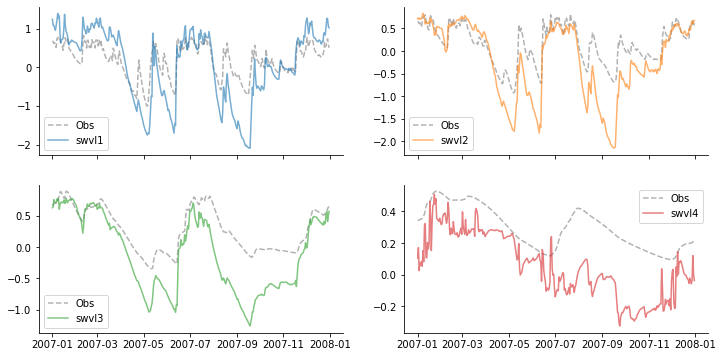

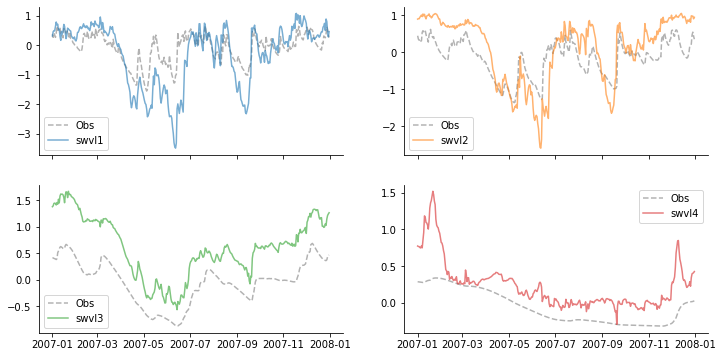

In [29]:
p = nonlinear_dict[target_var]["preds"]
time = "2007"

N = 2
pixels = np.random.choice(p.station_id.values, N, replace=False)

for px in pixels:
    f, axs = plt.subplots(2, 2, figsize=(12, 2*3), sharex=True)
    for ix, target_var in enumerate(target_vars):
        ax = axs[np.unravel_index(ix, (2, 2))]
        preds = nonlinear_dict[target_var]["preds"]
        data = preds.sel(station_id=px, time=time)

        ax.plot(data.time, data.obs, color="k", ls="--", alpha=0.3, label="Obs")
        ax.plot(data.time, data.sim, color=f"C{ix}", ls="-", alpha=0.6, label=f"{target_var}")
        ax.legend()
        sns.despine()

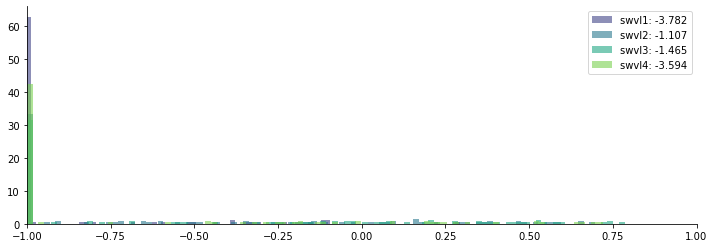

In [30]:
f, ax = plt.subplots(figsize=(12, 4))

colors = sns.color_palette("viridis", n_colors=len(target_vars))
for ix, target_var in enumerate(target_vars):
    errors = nonlinear_dict[target_var]["errors"]
    nse = errors["NSE"]

    ax.hist(nse.where(nse > -1, -1), bins=100, density=True, label=f"{target_var}: {nse.median().values:.3f}", alpha=0.6, color=colors[ix]);
    ax.axvline(nse.median(), color=colors[ix], ls="--", alpha=0.5)
    

ax.set_xlim(-1, 1)
ax.legend()
sns.despine()

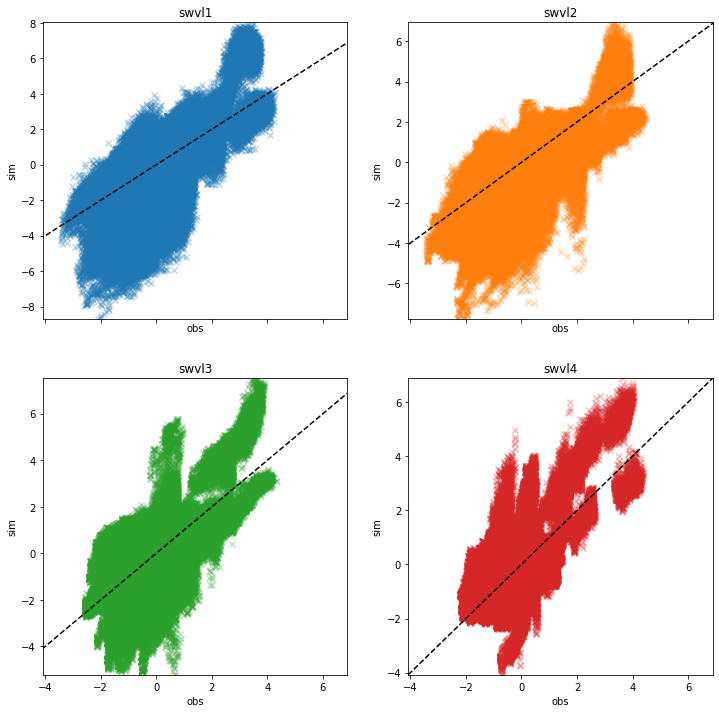

In [34]:
from scripts.plots import scatter_plot

if TARGET == "ESA":
    f, axs = plt.subplots(1, 2, figsize=(6 * 2, 6), sharex=True, sharey=True)
else:
    f, axs = plt.subplots(2, 2, figsize=(6 * 2, 6 * 2), sharex=True, sharey=False)

for ix, target_var in enumerate(target_vars):
    ax = axs[np.unravel_index(ix, (2, 2)) if TARGET != "ESA" else ix]
    preds = nonlinear_dict[target_var]["preds"]

    x, y = preds["obs"].values.flatten(), preds["sim"].values.flatten()
    scatter_plot(obs=x, sim=y, ax=ax, scatter_kwargs={"marker": "x", "color": f"C{ix}", "alpha": 0.3})
    ax.set_title(target_var)

# Marginalia

# Get training/test dataset

In [53]:
ds = xr.open_dataset("/home/tommy/spatio_temporal/data/ALL_dynamic_ds.nc")

def read_basin_list(txt_path: Path) -> pd.DataFrame:
    return pd.read_csv(txt_path, header=None).rename({0: "station_id"}, axis=1)


train_sids = read_basin_list(cfg.train_basin_file)
test_sids = read_basin_list(cfg.test_basin_file)
train_ds = ds.sel(time=slice(cfg.train_start_date, cfg.train_end_date), station_id=np.isin(ds.station_id, train_sids.station_id))
test_ds = ds.sel(time=slice(cfg.test_start_date, cfg.test_end_date), station_id=np.isin(ds.station_id, test_sids.station_id))

print(f"Out of Sample: {not all(np.isin(test_sids, train_sids))}")

Out of Sample: True


# Probe the basins

In [6]:
from scripts.cell_state.extract_cell_state import get_cell_states
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

subset = "train"
out_dir = run_dir / f"cell_states"
if not out_dir.exists():
    out_dir.mkdir(parents=True, exist_ok=True)

if not (out_dir / f"{subset}_cell_states.nc").exists():
    cn = get_cell_states(cfg, run_dir, subset=subset)
    cn.to_netcdf(out_dir / f"{subset}_cell_states.nc")
else:
    cn = xr.open_dataset(out_dir / f"{subset}_cell_states.nc")
    
train_cn = xr.open_dataset(out_dir / f"train_cell_states.nc")
test_cn = xr.open_dataset(out_dir / f"test_cell_states.nc")

# Normalisation strategy - global or local?

In [7]:
PER_BASIN = False  # True = PER BASIN

In [8]:
from scripts.cell_state.normalize import normalize_cstate
from scripts.cell_state.cell_state_dataset import dataset_dimensions_to_variable

fname_base = "per_basin" if PER_BASIN else "global"
if (out_dir / f"{fname_base}_train_cs.nc").exists():
    train_cs = xr.open_dataset(out_dir / f"{fname_base}_train_cs.nc")
else:
    train_norm_cs_data = normalize_cstate(train_cn, variable_str="c_n", per_basin=PER_BASIN, time_dim="date")
    train_cs = dataset_dimensions_to_variable(
        ds=train_norm_cs_data.to_dataset() if isinstance(train_norm_cs_data, xr.DataArray) else train_norm_cs_data,
        variable="c_n",
        dimension_to_convert_to_variable_dim="dimension",
        time_dim="date"
    )
    train_cs.to_netcdf(out_dir / f"{fname_base}_train_cs.nc")

In [9]:
if (out_dir / f"{fname_base}_test_cs.nc").exists():
    test_cs = xr.open_dataset(out_dir / f"{fname_base}_test_cs.nc")
else:
    test_norm_cs_data = normalize_cstate(test_cn, variable_str="c_n", per_basin=PER_BASIN, time_dim="date")
    test_cs = dataset_dimensions_to_variable(
        ds=test_norm_cs_data.to_dataset() if isinstance(test_norm_cs_data, xr.DataArray) else test_norm_cs_data,
        variable="c_n",
        dimension_to_convert_to_variable_dim="dimension",
        time_dim="date"
    )
    test_cs.to_netcdf(out_dir / f"{fname_base}_test_cs.nc")

In [10]:
train_cs["station_id"] = train_cs["station_id"].astype(int)
test_cs["station_id"] = test_cs["station_id"].astype(int)

train_cs = train_cs.rename({"date": "time"})
test_cs = test_cs.rename({"date": "time"})

# Target Data

In [11]:
TARGET = "ERA5"

In [12]:
from scripts.cell_state.normalize import normalize_2d_dataset



if TARGET == "ERA5":
    filepath = data_dir / "camels_basin_ERA5Land_sm.nc"
    era5_ds = xr.open_dataset(filepath)

    if not isinstance(era5_ds, xr.Dataset):
        era5_ds = era5_ds.to_dataset()

    for var in era5_ds.data_vars:
        era5_ds[var] = normalize_2d_dataset(era5_ds, variable_str=var, per_basin=PER_BASIN)

    era5_ds["station_id"] = era5_ds["station_id"].astype(int)

    # NOT for snow depth ..?
    era5_ds = era5_ds.drop("sd")
    target_ds = era5_ds

elif TARGET == "ESA":
    filepath = data_dir / "SOIL_MOISTURE/interp_full_timeseries_esa_cci_sm.nc"
    esa_ds = xr.open_dataset(filepath).drop("spatial_ref")
    if not isinstance(esa_ds, xr.Dataset):
        esa_ds = esa_ds.to_dataset()

    for var in esa_ds.data_vars:
        esa_ds[var] = normalize_2d_dataset(esa_ds, variable_str=var, per_basin=PER_BASIN)

    esa_ds["station_id"] = esa_ds["station_id"].astype(int)
    target_ds = esa_ds
else:
    assert False
    

# Train - Test DataLoaders

In [13]:
train_target_ds = target_ds.sel(station_id=train_cs.station_id, time=train_cs.time)
test_target_ds = target_ds.sel(station_id=np.isin(target_ds.station_id, test_cs.station_id), time=test_cs.time)

input_variables = list(train_cs.data_vars)
seq_length = 1
basin_dim = "station_id"
time_dim = "time"

In [14]:
# train_target_ds
# test_target_ds
# train_cs
# test_cs

<xarray.Dataset>
Dimensions:     (station_id: 134, time: 4018)
Coordinates:
  * time        (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
  * station_id  (station_id) int64 102001 107001 12001 ... 9004 94001 96001
Data variables: (12/64)
    dim0        (time, station_id) float32 ...
    dim1        (time, station_id) float32 ...
    dim2        (time, station_id) float32 ...
    dim3        (time, station_id) float32 ...
    dim4        (time, station_id) float32 ...
    dim5        (time, station_id) float32 ...
    ...          ...
    dim58       (time, station_id) float32 ...
    dim59       (time, station_id) float32 ...
    dim60       (time, station_id) float32 ...
    dim61       (time, station_id) float32 ...
    dim62       (time, station_id) float32 ...
    dim63       (time, station_id) float32 ...

In [15]:
from collections import defaultdict
from scripts.cell_state.timeseries_dataset import TimeSeriesDataset, get_time_basin_aligned_dictionary

if "all_train_test" not in globals():
    all_train_test = defaultdict(dict)
    for target_var in [v for v in target_ds.data_vars]:
        print(f"** STARTING {target_var} **")
        train_dataset = TimeSeriesDataset(
            input_data=train_cs,
            target_data=train_target_ds,
            target_variable=target_var,
            input_variables=input_variables,
            seq_length=seq_length,
            basin_dim=basin_dim,
            time_dim=time_dim,
            desc="Creating Train Samples",
        )

        train = get_time_basin_aligned_dictionary(train_dataset)

        test_dataset = TimeSeriesDataset(
            input_data=test_cs,
            target_data=test_target_ds,
            target_variable=target_var,
            input_variables=input_variables,
            seq_length=seq_length,
            basin_dim=basin_dim,
            time_dim=time_dim,
            desc="Creating Test Samples",
        )

        test = get_time_basin_aligned_dictionary(test_dataset)

        all_train_test[target_var]["train"] = train
        all_train_test[target_var]["test"] = test
else:
    print("Already loaded all_train_test data")

Creating Train Samples:   0%|          | 0/535 [00:00<?, ?it/s]

** STARTING swvl1 **


Extracting Data: 100%|██████████| 7618/7618 [01:00<00:00, 125.99it/s]


Merging and reshaping arrays


Creating Train Samples:   0%|          | 0/535 [00:00<?, ?it/s]

Merging and reshaping arrays
** STARTING swvl2 **


Extracting Data: 100%|██████████| 7621/7621 [00:56<00:00, 134.79it/s]


Merging and reshaping arrays


Creating Train Samples:   0%|          | 0/535 [00:00<?, ?it/s]

Merging and reshaping arrays
** STARTING swvl3 **


Extracting Data: 100%|██████████| 7618/7618 [01:00<00:00, 126.57it/s]


Merging and reshaping arrays


Creating Train Samples:   0%|          | 0/535 [00:00<?, ?it/s]

Merging and reshaping arrays
** STARTING swvl4 **


Extracting Data: 100%|██████████| 7618/7618 [01:01<00:00, 124.53it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 2087/2087 [00:16<00:00, 130.38it/s]


Merging and reshaping arrays


# Train Probe

In [16]:
from scripts.cell_state.sklearn_models import (
    init_linear_model,
    evaluate,
    create_analysis_dataset,
    fit_and_predict,
)
from scripts.cell_state.analysis import (save_probe_components, load_probe_components)

In [17]:
# initalise the model 
all_models_preds = defaultdict(dict)
target_vars = [v for v in target_ds.data_vars]

for target_var in [v for v in target_ds.data_vars]:
    print(f"** {target_var} **")
    model, preds, errors = fit_and_predict(all_train_test[target_var]["train"], all_train_test[target_var]["test"], random_seed=100)
    all_models_preds[target_var]["model"] = model
    all_models_preds[target_var]["preds"] = preds
    all_models_preds[target_var]["errors"] = errors
    
# save_probe_components(run_dir=run_dir, all_models_preds=all_models_preds)

** swvl1 **
-- Epoch 1
Norm: 0.96, NNZs: 42, Bias: -0.059347, T: 1755151, Avg. loss: 0.041190
Total training time: 1.25 seconds.
-- Epoch 2
Norm: 0.96, NNZs: 43, Bias: -0.061055, T: 3510302, Avg. loss: 0.041062
Total training time: 2.73 seconds.
-- Epoch 3
Norm: 0.95, NNZs: 43, Bias: -0.061896, T: 5265453, Avg. loss: 0.041060
Total training time: 4.20 seconds.
-- Epoch 4
Norm: 0.95, NNZs: 42, Bias: -0.062559, T: 7020604, Avg. loss: 0.041061
Total training time: 5.66 seconds.
Convergence after 4 epochs took 5.85 seconds


Calculating Errors: 100%|██████████| 133/133 [00:01<00:00, 78.53it/s, 102001]


** swvl2 **
-- Epoch 1
Norm: 0.86, NNZs: 37, Bias: -0.064648, T: 1755809, Avg. loss: 0.048683
Total training time: 1.33 seconds.
-- Epoch 2
Norm: 0.86, NNZs: 39, Bias: -0.060525, T: 3511618, Avg. loss: 0.048574
Total training time: 2.94 seconds.
-- Epoch 3
Norm: 0.86, NNZs: 39, Bias: -0.054302, T: 5267427, Avg. loss: 0.048572
Total training time: 4.47 seconds.
-- Epoch 4
Norm: 0.86, NNZs: 39, Bias: -0.061458, T: 7023236, Avg. loss: 0.048571
Total training time: 6.01 seconds.
Convergence after 4 epochs took 6.17 seconds


Calculating Errors: 100%|██████████| 133/133 [00:01<00:00, 83.74it/s, 102001]


** swvl3 **
-- Epoch 1
Norm: 0.96, NNZs: 43, Bias: -0.087814, T: 1755151, Avg. loss: 0.037055
Total training time: 1.24 seconds.
-- Epoch 2
Norm: 0.96, NNZs: 43, Bias: -0.093319, T: 3510302, Avg. loss: 0.036937
Total training time: 2.72 seconds.
-- Epoch 3
Norm: 0.96, NNZs: 44, Bias: -0.096478, T: 5265453, Avg. loss: 0.036931
Total training time: 4.34 seconds.
-- Epoch 4
Norm: 0.96, NNZs: 43, Bias: -0.088901, T: 7020604, Avg. loss: 0.036927
Total training time: 5.73 seconds.
Convergence after 4 epochs took 5.91 seconds


Calculating Errors: 100%|██████████| 133/133 [00:01<00:00, 75.62it/s, 102001]


** swvl4 **
-- Epoch 1
Norm: 0.97, NNZs: 44, Bias: -0.055269, T: 1755151, Avg. loss: 0.037614
Total training time: 1.43 seconds.
-- Epoch 2
Norm: 0.97, NNZs: 44, Bias: -0.060157, T: 3510302, Avg. loss: 0.037485
Total training time: 2.92 seconds.
-- Epoch 3
Norm: 0.96, NNZs: 45, Bias: -0.061462, T: 5265453, Avg. loss: 0.037486
Total training time: 4.32 seconds.
-- Epoch 4
Norm: 0.96, NNZs: 46, Bias: -0.056886, T: 7020604, Avg. loss: 0.037474
Total training time: 5.68 seconds.
Convergence after 4 epochs took 5.84 seconds


Calculating Errors: 100%|██████████| 133/133 [00:01<00:00, 73.64it/s, 102001]


In [35]:
# initalise the model 
all_train_preds = defaultdict(dict)
target_vars = [v for v in target_ds.data_vars]

for target_var in [v for v in target_ds.data_vars]:
    print(f"** {target_var} **")
    model, preds, errors = fit_and_predict(all_train_test[target_var]["train"], all_train_test[target_var]["train"], random_seed=100)
    all_train_preds[target_var]["model"] = model
    all_train_preds[target_var]["preds"] = preds
    all_train_preds[target_var]["errors"] = errors
    
# save_probe_components(run_dir=run_dir, all_models_preds=all_models_preds)

** swvl1 **
-- Epoch 1
Norm: 0.96, NNZs: 42, Bias: -0.059347, T: 1755151, Avg. loss: 0.041190
Total training time: 1.24 seconds.
-- Epoch 2
Norm: 0.96, NNZs: 43, Bias: -0.061055, T: 3510302, Avg. loss: 0.041062
Total training time: 2.59 seconds.
-- Epoch 3
Norm: 0.95, NNZs: 43, Bias: -0.061896, T: 5265453, Avg. loss: 0.041060
Total training time: 3.95 seconds.
-- Epoch 4
Norm: 0.95, NNZs: 42, Bias: -0.062559, T: 7020604, Avg. loss: 0.041061
Total training time: 5.33 seconds.
Convergence after 4 epochs took 5.46 seconds


Calculating Errors: 100%|██████████| 534/534 [00:06<00:00, 86.94it/s, 106001]


** swvl2 **
-- Epoch 1
Norm: 0.86, NNZs: 37, Bias: -0.064648, T: 1755809, Avg. loss: 0.048683
Total training time: 1.32 seconds.
-- Epoch 2
Norm: 0.86, NNZs: 39, Bias: -0.060525, T: 3511618, Avg. loss: 0.048574
Total training time: 2.77 seconds.
-- Epoch 3
Norm: 0.86, NNZs: 39, Bias: -0.054302, T: 5267427, Avg. loss: 0.048572
Total training time: 4.19 seconds.
-- Epoch 4
Norm: 0.86, NNZs: 39, Bias: -0.061458, T: 7023236, Avg. loss: 0.048571
Total training time: 5.65 seconds.
Convergence after 4 epochs took 5.78 seconds


Calculating Errors: 100%|██████████| 535/535 [00:06<00:00, 85.83it/s, 106001]


** swvl3 **
-- Epoch 1
Norm: 0.96, NNZs: 43, Bias: -0.087814, T: 1755151, Avg. loss: 0.037055
Total training time: 1.27 seconds.
-- Epoch 2
Norm: 0.96, NNZs: 43, Bias: -0.093319, T: 3510302, Avg. loss: 0.036937
Total training time: 2.67 seconds.
-- Epoch 3
Norm: 0.96, NNZs: 44, Bias: -0.096478, T: 5265453, Avg. loss: 0.036931
Total training time: 4.06 seconds.
-- Epoch 4
Norm: 0.96, NNZs: 43, Bias: -0.088901, T: 7020604, Avg. loss: 0.036927
Total training time: 5.45 seconds.
Convergence after 4 epochs took 5.58 seconds


Calculating Errors: 100%|██████████| 534/534 [00:06<00:00, 86.38it/s, 106001]


** swvl4 **
-- Epoch 1
Norm: 0.97, NNZs: 44, Bias: -0.055269, T: 1755151, Avg. loss: 0.037614
Total training time: 1.24 seconds.
-- Epoch 2
Norm: 0.97, NNZs: 44, Bias: -0.060157, T: 3510302, Avg. loss: 0.037485
Total training time: 2.60 seconds.
-- Epoch 3
Norm: 0.96, NNZs: 45, Bias: -0.061462, T: 5265453, Avg. loss: 0.037486
Total training time: 3.97 seconds.
-- Epoch 4
Norm: 0.96, NNZs: 46, Bias: -0.056886, T: 7020604, Avg. loss: 0.037474
Total training time: 5.32 seconds.
Convergence after 4 epochs took 5.45 seconds


Calculating Errors: 100%|██████████| 534/534 [00:06<00:00, 85.08it/s, 106001]
